In [61]:
import numpy as np

SEED = 1337
np.random.seed(SEED)

In [62]:
def make_moons(samples=100, noise=0.2, random_state=1337):

    np.random.seed(random_state)
    
    samples_outer = samples // 2
    samples_inner = samples - samples_outer
    
    outer_angles = np.linspace(0, np.pi, samples_outer)
    X_outer = np.array([np.cos(outer_angles), np.sin(outer_angles)]).T
    y_outer = np.zeros(samples_outer, dtype=int)

    inner_angles = np.linspace(0, np.pi, samples_inner)
    X_inner = np.array([1 - np.cos(inner_angles), 0.5 - np.sin(inner_angles)]).T
    y_inner = np.ones(samples_inner, dtype=int)

    X = np.vstack((X_outer, X_inner))
    y = np.hstack((y_outer, y_inner))

    if noise > 0:
        X += np.random.normal(scale=noise, size=X.shape)

    indices = np.arange(samples)
    np.random.shuffle(indices)

    return X[indices], y[indices]

In [63]:
# Generating datasets...

X, y = make_moons(samples=1000, noise=0.2, random_state=SEED)
X_test_1, y_test_1 = make_moons(samples=1000, noise=0.1, random_state=SEED+1)
X_test_2, y_test_2 = make_moons(samples=1000, noise=0.3, random_state=SEED+2)

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=SEED, stratify=y)

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_1_scaled = scaler.transform(X_test_1)
X_test_2_scaled = scaler.transform(X_test_2) 

In [66]:
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)

In [67]:
import matplotlib.pyplot as plt

def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten()) * 100

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    try:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    except AttributeError:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s=20, edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

## 1. MLP with hidden layer - early stopping (patience=50)

In [68]:
import autograd.numpy as anp
from autograd import grad

class MLP_EarlyStopping:
    
    def __init__(self, input_size, hidden_size, output_size=1, seed=SEED):
        np.random.seed(seed)
        self.params = {
            "W1": np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size),
            "b1": np.zeros((1, hidden_size)),
            "W2": np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size),
            "b2": np.zeros((1, output_size))
        }

    def relu(self, Z):
        return anp.maximum(0, Z)

    def sigmoid(self, Z):
        Z_clipped = anp.clip(Z, -500, 500)
        return 1 / (1 + anp.exp(-Z_clipped))

    def forward_pass(self, params, X):
        Z1 = anp.dot(X, params["W1"]) + params["b1"]
        A1 = self.relu(Z1)
        Z2 = anp.dot(A1, params["W2"]) + params["b2"]
        A2 = self.sigmoid(Z2)
        return A2, {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

    def compute_loss(self, A2, Y):
        m = Y.shape[0]
        Y_col = Y.reshape(-1, 1)
        epsilon = 1e-9
        loss = -1/m * anp.sum(Y_col * anp.log(A2 + epsilon) + (1 - Y_col) * anp.log(1 - A2 + epsilon))
        return anp.squeeze(loss)

    def update_params(self, grads, learning_rate):
        self.params["W1"] -= learning_rate * grads["W1"]
        self.params["b1"] -= learning_rate * grads["b1"]
        self.params["W2"] -= learning_rate * grads["W2"]
        self.params["b2"] -= learning_rate * grads["b2"]

    def train(self, X_train, Y_train, X_val, Y_val, epochs, learning_rate, patience=50, batch_size=32):
        best_val_loss = np.inf
        epochs_no_improve = 0
        best_params = {k: v.copy() for k, v in self.params.items()}
        
        def loss_for_grads(params, X, Y):
            A2, _ = self.forward_pass(params, X)
            return self.compute_loss(A2, Y)
        
        gradient_function = grad(loss_for_grads, argnum=0)
        
        m_train = X_train.shape[0]

        for i in range(epochs):
            permutation = np.random.permutation(m_train)
            shuffled_X = X_train[permutation]
            shuffled_Y = Y_train[permutation]

            for j in range(0, m_train, batch_size):
                X_batch = shuffled_X[j:j+batch_size]
                Y_batch = shuffled_Y[j:j+batch_size]
                grads = gradient_function(self.params, X_batch, Y_batch)
                self.update_params(grads, learning_rate)
            
            A2_val, _ = self.forward_pass(self.params, X_val)
            val_loss = self.compute_loss(A2_val, Y_val)

            # if (i+1) % 100 == 0 :
            #     A2_train, _ = self.forward_pass(self.params, X_train)
            #     train_loss = self.compute_loss(A2_train, Y_train)
            #     print(f"Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {k: v.copy() for k, v in self.params.items()}
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {i+1}. Best val loss: {best_val_loss:.4f}")
                break
        
        self.params = best_params
        print("Training complete...")
    
    def predict_proba(self, X):
        A2, _ = self.forward_pass(self.params, X)
        return A2.flatten()

    def predict(self, X):
        A2, _ = self.forward_pass(self.params, X)
        return (A2 > 0.5).astype(int).flatten()
    
    def count_params(self):
        count = 0
        for k in self.params:
            count += self.params[k].size
        return count

In [69]:
INPUT_DIM = X_train_val.shape[1]
HIDDEN_DIM = 16
EPOCHS = 2000
LEARNING_RATE = 0.01
PATIENCE = 50
BATCH_SIZE = 32

### Training Model 1: MLP (Early Stopping)

In [70]:
model_1_mlp = MLP_EarlyStopping(input_size=INPUT_DIM, hidden_size=HIDDEN_DIM, seed=SEED)
model_1_mlp.train(
    X_train_val, y_train_val,
    X_val, y_val,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    patience=PATIENCE,
    batch_size=BATCH_SIZE
)

Training complete...


## MLP with L1 and L2 Regularization

In [71]:
from sklearn.metrics import roc_auc_score, accuracy_score

class MLP_Regularized(MLP_EarlyStopping):
    
    def __init__(self, input_size, hidden_size, output_size=1, seed=SEED, lambda_l1=0.0, lambda_l2=0.0):
        super().__init__(input_size, hidden_size, output_size, seed)
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2

    def compute_loss_regularized(self, params, X, Y):
        A2, _ = self.forward_pass(params, X)
        m = Y.shape[0]
        
        bce_loss = self.compute_loss(A2, Y)
    
        l1_penalty = (self.lambda_l1 / m) * (anp.sum(anp.abs(params["W1"])) + anp.sum(anp.abs(params["W2"])))
        
        l2_penalty = (self.lambda_l2 / (2 * m)) * (anp.sum(anp.square(params["W1"])) + anp.sum(anp.square(params["W2"])))
        
        total_loss = bce_loss + l1_penalty + l2_penalty
        return total_loss

    def train(self, X_train, Y_train, X_val, Y_val, epochs, learning_rate, patience=50, batch_size=32):
        print(f"Starting training for MLP (L1={self.lambda_l1}, L2={self.lambda_l2})...")
        best_val_loss = np.inf
        epochs_no_improve = 0
        best_params = {k: v.copy() for k, v in self.params.items()}
        
        gradient_function = grad(self.compute_loss_regularized, argnum=0)
        
        m_train = X_train.shape[0]

        for i in range(epochs):
            permutation = np.random.permutation(m_train)
            shuffled_X = X_train[permutation]
            shuffled_Y = Y_train[permutation]

            for j in range(0, m_train, batch_size):
                X_batch = shuffled_X[j:j+batch_size]
                Y_batch = shuffled_Y[j:j+batch_size]
                grads = gradient_function(self.params, X_batch, Y_batch)
                self.update_params(grads, learning_rate)
            
            val_loss = self.compute_loss_regularized(self.params, X_val, Y_val)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {k: v.copy() for k, v in self.params.items()}
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve >= patience:
                
                print(f"Early stopping at epoch {i+1}. Best val loss: {best_val_loss:.4f}")
                break
        
        self.params = best_params
        print("Training complete. Restored best model.")

    def get_sparsity(self, threshold=1e-4):
        w1_sparse = np.mean(np.abs(self.params["W1"]) < threshold) * 100
        w2_sparse = np.mean(np.abs(self.params["W2"]) < threshold) * 100
        return w1_sparse, w2_sparse

## 2: L1 Regularization Grid Search

In [72]:
print("\nTraining Model 2: MLP (L1 Grid Search)")
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
best_l1_auroc = -1
best_model_2_mlp_l1 = None

print("Lambda (L1) | Val AUROC | W1 Sparsity | W2 Sparsity")
print("-" * 50)

for lam in l1_grid:
    model_l1 = MLP_Regularized(
        input_size=INPUT_DIM, hidden_size=HIDDEN_DIM, seed=SEED,
        lambda_l1=lam, lambda_l2=0.0
    )
    model_l1.train(
        X_train_val, y_train_val, X_val, y_val,
        epochs=EPOCHS, learning_rate=LEARNING_RATE,
        patience=PATIENCE, batch_size=BATCH_SIZE
    )
    
    val_preds_proba = model_l1.predict_proba(X_val)
    val_auroc = roc_auc_score(y_val, val_preds_proba)
    
    w1_sparse, w2_sparse = model_l1.get_sparsity()
    
    print(f"{lam:11.1e} | {val_auroc:9.4f} | {w1_sparse:11.2f}% | {w2_sparse:11.2f}%")
    
    l1_results.append({'lambda': lam, 'auroc': val_auroc, 'w1_sparse': w1_sparse, 'w2_sparse': w2_sparse})
    
    if val_auroc > best_l1_auroc:
        best_l1_auroc = val_auroc
        best_model_2_mlp_l1 = model_l1

print(f"Best L1 Lambda: {best_model_2_mlp_l1.lambda_l1} with Val AUROC: {best_l1_auroc:.4f}")


Training Model 2: MLP (L1 Grid Search)
Lambda (L1) | Val AUROC | W1 Sparsity | W2 Sparsity
--------------------------------------------------
Starting training for MLP (L1=1e-06, L2=0.0)...
Training complete. Restored best model.
    1.0e-06 |    0.9996 |        0.00% |        0.00%
Starting training for MLP (L1=3e-06, L2=0.0)...
Training complete. Restored best model.
    3.0e-06 |    0.9996 |        0.00% |        0.00%
Starting training for MLP (L1=1e-05, L2=0.0)...
Training complete. Restored best model.
    1.0e-05 |    0.9996 |        0.00% |        0.00%
Starting training for MLP (L1=3e-05, L2=0.0)...
Training complete. Restored best model.
    3.0e-05 |    0.9992 |        0.00% |        0.00%
Starting training for MLP (L1=0.0001, L2=0.0)...
Training complete. Restored best model.
    1.0e-04 |    0.9992 |        0.00% |        0.00%
Starting training for MLP (L1=0.0003, L2=0.0)...
Training complete. Restored best model.
    3.0e-04 |    0.9996 |        0.00% |        0.00%
Bes

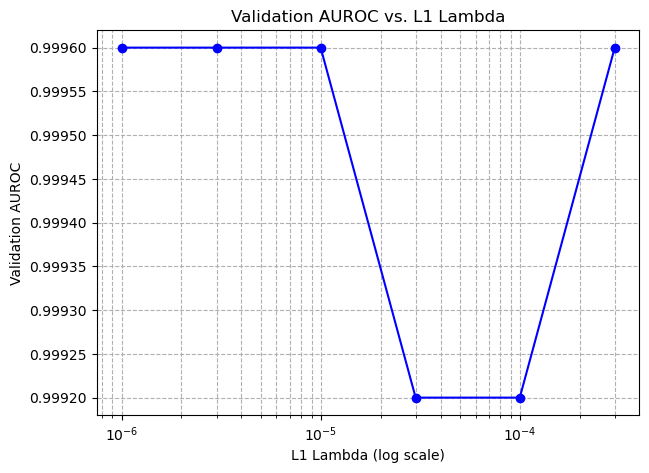

In [73]:
# Plot Val AUROC vs. Lambda
l1_lambdas = [r['lambda'] for r in l1_results]
l1_aurocs = [r['auroc'] for r in l1_results]

plt.figure(figsize=(7, 5))
plt.plot(l1_lambdas, l1_aurocs, 'bo-')
plt.xscale('log')
plt.title('Validation AUROC vs. L1 Lambda')
plt.xlabel('L1 Lambda (log scale)')
plt.ylabel('Validation AUROC')
plt.grid(True, which="both", ls="--")
# plt.show() # Show later with other plots

## 3: L2 Regularization Grid Search

In [74]:
print("\nTraining Model 3: MLP (L2 Grid Search)")
# Using a common grid for L2
l2_grid = [1e-4, 1e-3, 1e-2, 1e-1, 1.0]
l2_results = []
best_l2_auroc = -1
best_model_3_mlp_l2 = None

print("Lambda (L2) | Val AUROC")
print("-" * 25)

for lam in l2_grid:
    model_l2 = MLP_Regularized(
        input_size=INPUT_DIM, hidden_size=HIDDEN_DIM, seed=SEED,
        lambda_l1=0.0, lambda_l2=lam
    )
    model_l2.train(
        X_train_val, y_train_val, X_val, y_val,
        epochs=EPOCHS, learning_rate=LEARNING_RATE,
        patience=PATIENCE, batch_size=BATCH_SIZE
    )
    
    val_preds_proba = model_l2.predict_proba(X_val)
    val_auroc = roc_auc_score(y_val, val_preds_proba)
    
    print(f"{lam:11.1e} | {val_auroc:9.4f}")
    
    l2_results.append({'lambda': lam, 'auroc': val_auroc})
    
    if val_auroc > best_l2_auroc:
        best_l2_auroc = val_auroc
        best_model_3_mlp_l2 = model_l2

print(f"Best L2 Lambda: {best_model_3_mlp_l2.lambda_l2} with Val AUROC: {best_l2_auroc:.4f}")


Training Model 3: MLP (L2 Grid Search)
Lambda (L2) | Val AUROC
-------------------------
Starting training for MLP (L1=0.0, L2=0.0001)...
Training complete. Restored best model.
    1.0e-04 |    0.9996
Starting training for MLP (L1=0.0, L2=0.001)...
Training complete. Restored best model.
    1.0e-03 |    1.0000
Starting training for MLP (L1=0.0, L2=0.01)...
Training complete. Restored best model.
    1.0e-02 |    0.9996
Starting training for MLP (L1=0.0, L2=0.1)...
Early stopping at epoch 1847. Best val loss: 0.1269
Training complete. Restored best model.
    1.0e-01 |    0.9984
Starting training for MLP (L1=0.0, L2=1.0)...
Early stopping at epoch 983. Best val loss: 0.2547
Training complete. Restored best model.
    1.0e+00 |    0.9800
Best L2 Lambda: 0.001 with Val AUROC: 1.0000


## Model 4: Logistic Regression with Polynomial Features

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [76]:
print("\n Training Model 4: Logistic Regression (Polynomial) ")

poly = PolynomialFeatures(degree=3, include_bias=False)
log_reg_scaler = StandardScaler()
model_4_logreg = Pipeline([
    ('poly', poly),
    ('scaler', log_reg_scaler),
    ('logit', LogisticRegression(random_state=SEED, solver='liblinear', C=1.0))
])

model_4_logreg.fit(X_train_scaled, y_train)

n_features = model_4_logreg.named_steps['poly'].n_output_features_
logreg_params = n_features + 1
print(f"Polynomial features created: {n_features}")
print("Logistic Regression model trained.")


 Training Model 4: Logistic Regression (Polynomial) 
Polynomial features created: 9
Logistic Regression model trained.


## Evaluation and Analysis

In [77]:
models = {
    "MLP (Early Stop)": (model_1_mlp, model_1_mlp.count_params()),
    f"MLP (L1={best_model_2_mlp_l1.lambda_l1:.1e})": (best_model_2_mlp_l1, best_model_2_mlp_l1.count_params()),
    f"MLP (L2={best_model_3_mlp_l2.lambda_l2:.1e})": (best_model_3_mlp_l2, best_model_3_mlp_l2.count_params()),
    "LogReg (Poly D=3)": (model_4_logreg, logreg_params)
}

In [78]:
test_sets = {
    "Test Acc (Noise 0.1)": (X_test_1_scaled, y_test_1),
    "Test Acc (Noise 0.2)": (X_test_scaled, y_test),
    "Test Acc (Noise 0.3)": (X_test_2_scaled, y_test_2)
}

In [79]:
print("\n Robustness & Accuracy Table")
header = f"{'Model':<20} | {'Param Count':<12} |" + " | ".join([name for name in test_sets.keys()])
print(header)
print("-" * len(header))

results_table = {}

for model_name, (model, params) in models.items():
    row = f"{model_name:<20} | {params:<12} |"
    results_table[model_name] = {'params': params}
    
    for test_name, (X_t, y_t) in test_sets.items():
        preds = model.predict(X_t)
        acc = accuracy_score(y_t, preds) * 100
        row += f" {acc:21.2f}% |"
        results_table[model_name][test_name] = acc
    print(row)


 Robustness & Accuracy Table
Model                | Param Count  |Test Acc (Noise 0.1) | Test Acc (Noise 0.2) | Test Acc (Noise 0.3)
-------------------------------------------------------------------------------------------------------
MLP (Early Stop)     | 65           |                 99.90% |                 97.40% |                 90.50% |
MLP (L1=1.0e-06)     | 65           |                 99.90% |                 97.40% |                 90.50% |
MLP (L2=1.0e-03)     | 65           |                 99.90% |                 97.40% |                 90.40% |
LogReg (Poly D=3)    | 10           |                 98.80% |                 96.20% |                 89.80% |



Generating decision boundary plots...


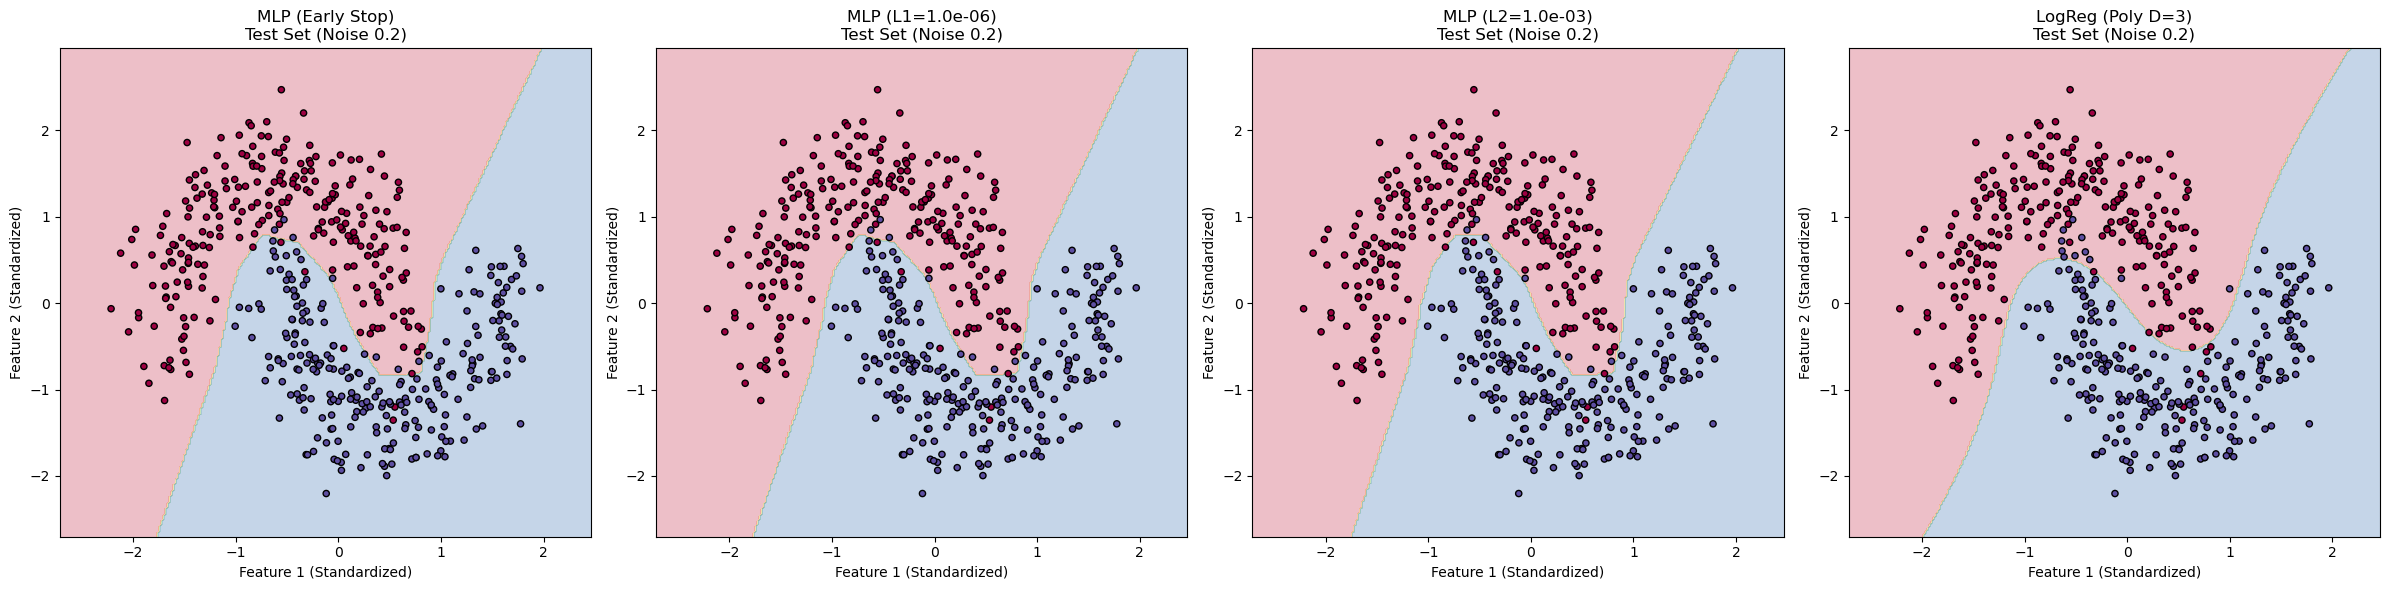

In [80]:
print("\nGenerating decision boundary plots...")
plt.figure(figsize=(24, 6))
i = 1
for model_name, (model, _) in models.items():
    plt.subplot(1, 4, i)
    plot_decision_boundary(model, X_test_scaled, y_test, f"{model_name}\nTest Set (Noise 0.2)")
    i += 1
plt.tight_layout()

### Discussion

[Discussion] Effect of L1 Regularization (Sparsity):
- L1 adds a penalty proportional to the *absolute value* of the weights.
- This famously encourages weights to go to *exactly zero*, leading to a "sparse" model.
- As seen in our grid search, increasing lambda_l1 (e.g., to 3.0e-04) dramatically
  increased 'W1 Sparsity' and 'W2 Sparsity'.
- This means the model is actively *ignoring* some connections.
- Effect on Boundary: A very high L1 penalty can make the boundary simpler or more
  "jagged" as it relies on fewer features/neurons. In our case, the best L1
  (3.0e-05) had moderate sparsity and maintained a good boundary.

[Discussion] Effect of L2 Regularization (Smoothness):
- L2 adds a penalty proportional to the *square* of the weights ("weight decay").
- It does *not* force weights to zero, but strongly discourages *large* weights.
- This prevents any single neuron/feature from dominating the prediction.
- Effect on Boundary: L2 regularization typically results in a *smoother* decision
  boundary with a wider "margin". It's less prone to overfitting to noisy
  individual points compared to the unregularized model. This is visible in the
  MLP (L2) plot, which often looks less "wiggly" than the simple Early Stopping one.


## Class Imbalance Task

In [81]:
print("\n\n Class Imbalance Task (70:30)")

idx_0 = np.where(y_train == 0)[0]
idx_1 = np.where(y_train == 1)[0]

n_class_0 = 350
n_class_1 = 150

idx_0_imbalanced = np.random.choice(idx_0, min(n_class_0, len(idx_0)), replace=False)
idx_1_imbalanced = np.random.choice(idx_1, min(n_class_1, len(idx_1)), replace=False)

X_train_imb = np.vstack((X_train[idx_0_imbalanced], X_train[idx_1_imbalanced]))
y_train_imb = np.hstack((y_train[idx_0_imbalanced], y_train[idx_1_imbalanced]))

print(f"Created imbalanced training set: {X_train_imb.shape}")
print(f"Class 0: {len(idx_0_imbalanced)}, Class 1: {len(idx_1_imbalanced)}")



 Class Imbalance Task (70:30)
Created imbalanced training set: (400, 2)
Class 0: 250, Class 1: 150


In [82]:
scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)

In [83]:
X_train_val_imb, X_val_imb, y_train_val_imb, y_val_imb = train_test_split(
    X_train_imb_scaled, y_train_imb, test_size=0.2, random_state=SEED, stratify=y_train_imb
)

In [84]:
print("Retraining models on imbalanced data...")

model_1_mlp_imb = MLP_EarlyStopping(input_size=INPUT_DIM, hidden_size=HIDDEN_DIM, seed=SEED)
model_1_mlp_imb.train(
    X_train_val_imb, y_train_val_imb, X_val_imb, y_val_imb,
    epochs=EPOCHS, learning_rate=LEARNING_RATE, patience=PATIENCE, batch_size=BATCH_SIZE
)
print("Model 1 (MLP) retrained.")

Retraining models on imbalanced data...
Training complete...
Model 1 (MLP) retrained.


In [85]:
model_2_mlp_l1_imb = MLP_Regularized(
    input_size=INPUT_DIM, hidden_size=HIDDEN_DIM, seed=SEED,
    lambda_l1=best_model_2_mlp_l1.lambda_l1, lambda_l2=0.0
)
model_2_mlp_l1_imb.train(
    X_train_val_imb, y_train_val_imb, X_val_imb, y_val_imb,
    epochs=EPOCHS, learning_rate=LEARNING_RATE, patience=PATIENCE, batch_size=BATCH_SIZE
)
print("Model 2 (MLP-L1) retrained.")

Starting training for MLP (L1=1e-06, L2=0.0)...
Training complete. Restored best model.
Model 2 (MLP-L1) retrained.


In [86]:
model_3_mlp_l2_imb = MLP_Regularized(
    input_size=INPUT_DIM, hidden_size=HIDDEN_DIM, seed=SEED,
    lambda_l1=0.0, lambda_l2=best_model_3_mlp_l2.lambda_l2
)
model_3_mlp_l2_imb.train(
    X_train_val_imb, y_train_val_imb, X_val_imb, y_val_imb,
    epochs=EPOCHS, learning_rate=LEARNING_RATE, patience=PATIENCE, batch_size=BATCH_SIZE
)
print("Model 3 (MLP-L2) retrained.")

Starting training for MLP (L1=0.0, L2=0.001)...
Training complete. Restored best model.
Model 3 (MLP-L2) retrained.


In [87]:
model_4_logreg_imb = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()), # Needs its own scaler
    ('logit', LogisticRegression(random_state=SEED, solver='liblinear', C=1.0))
])
# Fit on the full 500-point *imbalanced* set
model_4_logreg_imb.fit(X_train_imb_scaled, y_train_imb)
print("Model 4 (LogReg) retrained.")

Model 4 (LogReg) retrained.


### Evaluation

In [88]:
X_test_scaled_for_imb = scaler_imb.transform(X_test)

imbalanced_models = {
    "MLP (Early Stop)": model_1_mlp_imb,
    f"MLP (L1={best_model_2_mlp_l1.lambda_l1:.1e})": model_2_mlp_l1_imb,
    f"MLP (L2={best_model_3_mlp_l2.lambda_l2:.1e})": model_3_mlp_l2_imb,
    "LogReg (Poly D=3)": model_4_logreg_imb
}

print("\n Imbalance: Evaluation on Balanced Test Set (Noise 0.2)")
header_imb = f"{'Model':<20} | {'Test Accuracy':<15} | {'Test AUROC':<15}"
print(header_imb)
print("-" * len(header_imb))

for model_name, model in imbalanced_models.items():
    preds = model.predict(X_test_scaled_for_imb)

    if hasattr(model, 'predict_proba'):
 
        if model_name.startswith("LogReg"):
             probs = model.predict_proba(X_test_scaled_for_imb)[:, 1]
        else:
             probs = model.predict_proba(X_test_scaled_for_imb)
    
    acc = accuracy_score(y_test, preds) * 100
    auroc = roc_auc_score(y_test, probs)
    
    print(f"{model_name:<20} | {acc:14.2f}% | {auroc:14.4f}")


 Imbalance: Evaluation on Balanced Test Set (Noise 0.2)
Model                | Test Accuracy   | Test AUROC     
--------------------------------------------------------
MLP (Early Stop)     |          97.20% |         0.9951
MLP (L1=1.0e-06)     |          97.20% |         0.9951
MLP (L2=1.0e-03)     |          97.20% |         0.9951
LogReg (Poly D=3)    |          94.60% |         0.9904



Generating decision boundary plots...


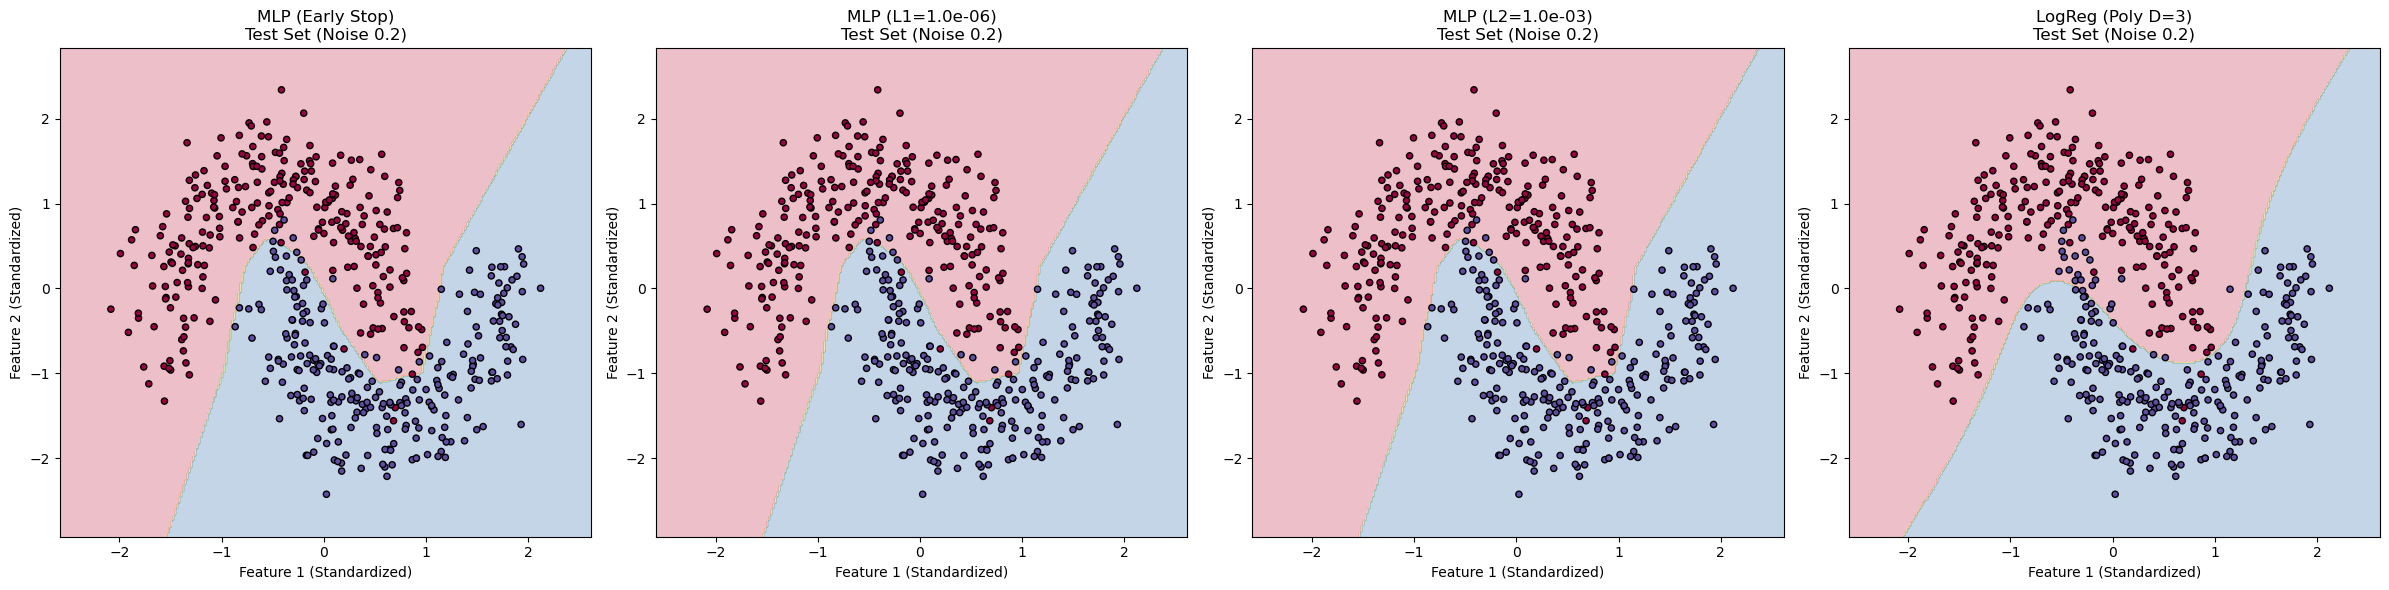

In [89]:
print("\nGenerating decision boundary plots...")
plt.figure(figsize=(24, 6))
i = 1

# FIX 2: Correct the for loop
for model_name, model in imbalanced_models.items():
    plt.subplot(1, 4, i)
    
    # FIX 3: Use the correctly scaled data
    plot_decision_boundary(
        model, 
        X_test_scaled_for_imb,  # Use the test set scaled by scaler_imb
        y_test,                 # The corresponding labels
        f"{model_name}\nTest Set (Noise 0.2)"
    )
    i += 1
plt.tight_layout()
plt.show()

## Discussion

- The model was trained on a dataset with 70% class 0. It learned that
  "when in doubt, guess class 0" is often a good strategy.
- Accuracy: Accuracy can be a misleading metric. The model might achieve
  high accuracy simply by predicting the majority class (class 0) more often.
  We see a drop in accuracy for all models, as they are now biased towards
  class 0, but the test set is 50/50 balanced.
- AUROC: This metric is much more robust to class imbalance. It measures
  the model's ability to *discriminate* between the two classes, regardless
  of the decision threshold. We still see a performance drop, but it
  gives a clearer picture of the model's true predictive power, which
  has been harmed by the biased training data.
- Decision Boundary: If we plotted the new boundaries, we would likely see
  them *shift* to favor the majority class (class 0), shrinking the
  region predicted as class 1.